In [395]:
import joblib
import numpy as np

In [478]:
costs = joblib.load("costs_latest.pkl")

[Array(3.4987848, dtype=float32), Array(3.2150023, dtype=float32), Array(3.298746, dtype=float32), Array(3.0284534, dtype=float32), Array(2.738771, dtype=float32), Array(2.696767, dtype=float32), Array(2.8225656, dtype=float32), Array(2.5053632, dtype=float32), Array(2.4097888, dtype=float32), Array(2.3165414, dtype=float32), Array(2.318062, dtype=float32), Array(2.053316, dtype=float32), Array(2.1210828, dtype=float32), Array(1.9737443, dtype=float32), Array(2.0134034, dtype=float32), Array(1.9625021, dtype=float32), Array(1.7738284, dtype=float32), Array(1.7391698, dtype=float32), Array(1.708358, dtype=float32), Array(1.5941063, dtype=float32), Array(1.892951, dtype=float32), Array(1.7257013, dtype=float32), Array(1.3617667, dtype=float32), Array(1.2939291, dtype=float32), Array(1.4514868, dtype=float32), Array(1.4385083, dtype=float32), Array(4.6279488, dtype=float32), Array(1.6034962, dtype=float32), Array(1.5886632, dtype=float32), Array(1.3406203, dtype=float32), Array(1.0366317,

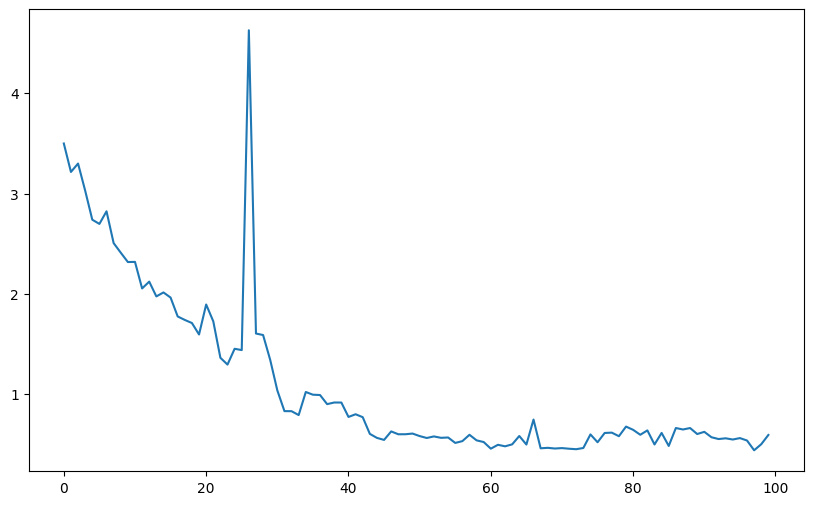

In [479]:
import matplotlib.pyplot as plt

print(costs)
# Plot the costs
plt.figure(figsize=(10, 6))
cost = np.array(costs).T

plt.plot(cost, label=f'Cost')
